## Imagenet_V2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
imagenet_v2, info=tfds.load('imagenet_v2', with_info=True,split='test')

In [5]:
print(imagenet_v2)

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64}>


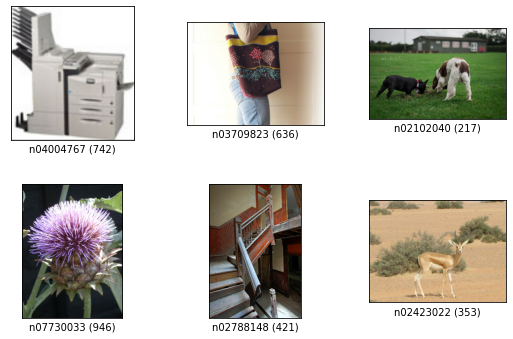

In [7]:
tfds.show_examples(imagenet_v2.take(6), info)
print()

## Model

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import (DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D,
GlobalMaxPooling2D, BatchNormalization, Conv2D, ReLU) 


def get_MobileNet(input_shape,
                  alpha=1.0,
                  depth_multiplier=1):

    img_input=tf.keras.Input(shape=input_shape)
    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier)
    
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2))
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier)
    
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,
                              strides=(2, 2))
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier)
    
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier,
                              strides=(2, 2))
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier)

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2))
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier)
    model = tf.keras.models.Model(img_input, x)

    return model

def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    filters = int(filters * alpha)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(inputs)
    x = Conv2D(filters, kernel,
               padding='valid',
               use_bias=False,
               strides=strides)(x)
    x = BatchNormalization(axis=-1)(x)
    return ReLU(6.)(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1)):
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    if strides == (1, 1):
        x = inputs
    else:
        x = ZeroPadding2D(((0, 1), (0, 1)))(inputs)
    x = DepthwiseConv2D((3, 3),
                        padding='same' if strides == (1, 1) else 'valid',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False)(x)
    x = BatchNormalization(
        axis=-1)(x)
    x = ReLU(6.)(x)

    x = Conv2D(pointwise_conv_filters, (1, 1),
               padding='same',
               use_bias=False,
               strides=(1, 1))(x)
    x = BatchNormalization(axis=-1)(x)
    return ReLU(6.)(x)

def add_top(core, n_classes):
    inputs=tf.keras.Input(core.layers[0].input.shape[1:])
    x = core(inputs)
    x = GlobalAveragePooling2D(keepdims=True)(x)
    x = tf.keras.layers.Dropout(0.001)(x)
    x = Conv2D(n_classes, (1, 1), padding='same')(x)
    x = tf.keras.layers.Reshape((n_classes,))(x)
    return tf.keras.Model(inputs,x)


In [9]:
IMG_LEN=224
NO_CLASSES=1000
NO_BREEDS = 120
def preprocess_imgnet(ds_row):
    image = tf.image.resize(ds_row['image'], (IMG_LEN, IMG_LEN), method='nearest')
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    # Onehot encoding labels
    label = tf.one_hot(ds_row['label'], NO_CLASSES)
    return image, label
def preprocess_sf_dogs(ds_row):
    image = tf.image.resize(ds_row['image'], (IMG_LEN, IMG_LEN), method='nearest')
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    # Onehot encoding labels
    label = tf.one_hot(ds_row['label'], NO_BREEDS)
    return image, label

def prepare(dataset, preprocess_fn, batch_size=32):
    ds = dataset.map(preprocess_fn, num_parallel_calls=6)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

## Learn on imagenet

In [64]:
imagenet=prepare(imagenet_v2, preprocess_imgnet, 32)

In [13]:
NO_EPOCHS=1

IMG_SIZE = (IMG_LEN, IMG_LEN, 3)
model = get_MobileNet(IMG_SIZE)
model = add_top(model,NO_CLASSES)
crossentropy=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
RMSprop=tf.keras.optimizers.RMSprop(1e-3)
model.compile(optimizer=RMSprop, loss=crossentropy, metrics=['accuracy', 'top_k_categorical_accuracy'])

#model.fit(ds,epochs=3)
    

## Transfer learnign for fine grained classification

In [10]:
sf_dogs, info = tfds.load(name="stanford_dogs", with_info=True)
sf_dogs_train=prepare(sf_dogs['train'], preprocess_sf_dogs, 32)
sf_dogs_val=prepare(sf_dogs['test'], preprocess_sf_dogs, 32)


In [14]:
model=get_MobileNet(IMG_SIZE)
model.load_weights("/home/pior/.keras/models/mobilenet_1_0_224_tf_no_top.h5")
model.trainable=False
model=add_top(model,NO_BREEDS)

In [ ]:
crossentropy=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
RMSprop=tf.keras.optimizers.RMSprop(1e-3)
model.compile(optimizer=RMSprop, loss=crossentropy, metrics=['accuracy', 'top_k_categorical_accuracy'])
model.fit(sf_dogs_train, validation_data=sf_dogs_val ,epochs=30)

Epoch 1/30
375/375 [==============================] - 172s 454ms/step - loss: 1.9584 - accuracy: 0.5057 - top_k_categorical_accuracy: 0.7967 - val_loss: 1.0815 - val_accuracy: 0.6728 - val_top_k_categorical_accuracy: 0.9383
Epoch 2/30
375/375 [==============================] - 169s 449ms/step - loss: 0.6936 - accuracy: 0.7882 - top_k_categorical_accuracy: 0.9733 - val_loss: 0.8162 - val_accuracy: 0.7458 - val_top_k_categorical_accuracy: 0.9599
Epoch 3/30
375/375 [==============================] - 165s 439ms/step - loss: 0.4584 - accuracy: 0.8606 - top_k_categorical_accuracy: 0.9857 - val_loss: 0.7578 - val_accuracy: 0.7578 - val_top_k_categorical_accuracy: 0.9654
Epoch 4/30
375/375 [==============================] - 151s 401ms/step - loss: 0.3326 - accuracy: 0.9020 - top_k_categorical_accuracy: 0.9927 - val_loss: 0.7610 - val_accuracy: 0.7649 - val_top_k_categorical_accuracy: 0.9677
Epoch 5/30
375/375 [==============================] - 156s 416ms/step - loss: 0.2537 - accuracy: 0.9247 

### Fine tuning

In [75]:
for layer in model.layers:
    layer.trainable=True

In [78]:
model.fit(sf_dogs_train, validation_data=sf_dogs_val ,epochs=30)

Epoch 1/30
375/375 [==============================] - 152s 404ms/step - loss: 0.0261 - accuracy: 0.9942 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.9308 - val_accuracy: 0.7713 - val_top_k_categorical_accuracy: 0.9678
Epoch 2/30
375/375 [==============================] - 151s 402ms/step - loss: 0.0223 - accuracy: 0.9960 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.9557 - val_accuracy: 0.7752 - val_top_k_categorical_accuracy: 0.9692
Epoch 3/30
375/375 [==============================] - 150s 400ms/step - loss: 0.0207 - accuracy: 0.9958 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.9648 - val_accuracy: 0.7758 - val_top_k_categorical_accuracy: 0.9682
Epoch 4/30
375/375 [==============================] - 153s 408ms/step - loss: 0.0165 - accuracy: 0.9962 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.9797 - val_accuracy: 0.7740 - val_top_k_categorical_accuracy: 0.9693
Epoch 5/30
375/375 [==============================] - 155s 410ms/step - loss: 0.0175 - accuracy: 0.9962 

KeyboardInterrupt: 